In [1]:
#@title Configuration
from google.colab import drive
import os
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"


Mounted at /content/drive


In [2]:
#@title Initialization { display-mode: "both" }
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

In [3]:
#@title Common Imports
from pyspark import SparkContext, SparkConf
import sys
import json
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate()
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import widgets
from IPython.display import display

from math import sqrt
from os.path import exists

File path, Folder ID, Constants and other related information

In [4]:
#@title File path, Folder ID, Constants
drivepath = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVData"
driveDAILYpath = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVCumulative"


In [5]:
#@title Load Coin names from the tickers file
#tickers = open(drivepath+"/tickers" ,"r")
#tfile = json.load(tickers)
#tickers.close()

#coins = list(tfile.keys())
#USDTcoins = [s for s in coins if "usdt" in s]

fileRef = open(driveDAILYpath+"/USDTCoinName.txt" ,"r")
coinName = []
coinCode = []
for lines in fileRef:
  name = eval(lines[:-1])
  coinName.append(name[1])
  coinCode.append(name)

## **Interactive Display for Trend Trading Indicators**

Choose the coin to start processing

In [8]:
#@title Select the Coin
TTIVal = ["Moving Average", "MACD", "RSI", "Stochastic RSI", "Standard Deviation"]

coin = widgets.Dropdown(
    options=coinName,
    value=coinName[0],
    description='Select Coin: ',
    disabled=False,
)

display(coin)

Dropdown(description='Select Coin: ', options=('Tether', 'Bitcoin', 'TRON', 'XRP', 'EOS', 'Ethereum', 'ICON', …

Processing the selected coin. Run the next columns for output

In [9]:
#@title Loading Coin Details
coinChosen = [item for item in coinCode if item[1] == coin.value]
coinname = coin.value
coinfile = driveDAILYpath+"/"+coinChosen[0][0]+"DAILY.csv"


p0 = spark.read.option("header",True).option("inferSchema",True).csv(coinfile)
p2 = p0.drop("_c0")
window = Window.orderBy("Date")

In [27]:
#@title TTI Calculations
def calcSD(path):
  coinfile = sc.textFile(path)

  answer = [tuple((coinname, 0))]

  # Convert to Key-Value RDD with city:list of all cols
  coinRDD = coinfile.map(lambda l : (l.split(",")[1], l.split(","))).filter(lambda kv : kv[1][1] != "Date").cache()
   
  
  # Map values and take only 'close' Price column
  closeRDD = coinRDD.map(lambda l: (l[0][:7], float(l[1][5])))

  aggRDD = closeRDD.aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                    lambda a,b: (a[0] + b[0], a[1] + b[1]))
  

  # Calculate mean and store it in meanRdd
  meanRDD = aggRDD.mapValues(lambda v: v[0]/v[1]).sortBy(lambda l: l[0])

  # Join closing Price Rdd with Mean Rdd for SD calculation
  joinRDD = closeRDD.join(meanRDD)

  # Map Xi and X_Avg values to (Xi - X_Avg)^2
  sqRDD = joinRDD.mapValues(lambda l: (l[0]-l[1]) *(l[0]-l[1]))

  sqSumRdd = sqRDD.aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                    lambda a,b: (a[0] + b[0], a[1] + b[1]))

  # Calculate Sqrt of Mean of Sum^2 and Calculate SD
  stdRdd = sqSumRdd.mapValues(lambda v: sqrt(v[0]/v[1])).sortBy(lambda l: l[0])  
  answer = stdRdd

  return answer


In [28]:
#@title TTI Calculations
#RSI
p3 = p2.withColumn("Diff", F.col("Close") - F.lag(F.col("Close"), 1, 0)\
                   .over(window)).drop("Close") 
p4 = p3.withColumn("Gain",F.when((F.col("Diff")>0),F.col("Diff")).otherwise(0))\
      .withColumn("Loss",F.when((F.col("Diff")<0),(F.col("Diff")*-1)).otherwise(0)).drop("Diff")

w = (Window.orderBy(F.col("Date")).rowsBetween(-14, 0))
p5 = p4.withColumn('rolling_gain', F.avg("Gain").over(w))\
      .withColumn('rolling_loss', F.avg("Loss").over(w))\
      .drop("Gain").drop("Loss")
p6 = p5.withColumn('RSI',F.expr("100-(100/(1+(rolling_gain/rolling_loss)))"))\
      .drop("rolling_gain").drop("rolling_loss").fillna(0)
RSI = p6.select("Date", "RSI")
#RSI.show()


#moving average
w1 = (Window.orderBy(F.col("Date")).rowsBetween(-50, 0))
p7 = p2.withColumn('Moving_average', F.avg("Close").over(w1))
MovingAvg = p7.select("Date", "Moving_average")
#MovingAvg.show()



#schoastic RSI
p8 = p6.withColumn('Min_RSI', F.min("RSI").over(w))\
        .withColumn('Max_RSI', F.max("RSI").over(w))
p9 = p8.withColumn('SRSI',F.expr("(RSI-Min_RSI)/(Max_RSI-Min_RSI)"))
SRSI = p9.select("Date", "SRSI")
#SRSI.show()


#MACD
w2 = (Window.orderBy(F.col("Date")).rowsBetween(-12, 0))
w3 = (Window.orderBy(F.col("Date")).rowsBetween(-26, 0))
w4 = (Window.orderBy(F.col("Date")).rowsBetween(-9, 0))
p10 = p7.withColumn('Exp_Mov_avg_12', F.avg("Moving_average").over(w2))\
        .withColumn('Exp_Mov_avg_26', F.avg("Moving_average").over(w3))
p11 = p10.withColumn('Signal_line', F.expr("Exp_Mov_avg_12-Exp_Mov_avg_26"))
p12 = p11.withColumn('MACD', F.avg("Signal_line").over(w4))
MACD = p12.select("Date", "MACD")
#MACD.show()

SD = calcSD(coinfile)

In [12]:
#@title Select TTI
TTI = widgets.Dropdown(
    options=TTIVal,
    value=TTIVal[0],
    description='Select TTI: ',
    disabled=False,
)
display(TTI)

Dropdown(description='Select TTI: ', options=('Moving Average', 'MACD', 'RSI', 'Stochastic RSI', 'Standard Dev…

## **Interactive Display for Trend Trading Indicators**


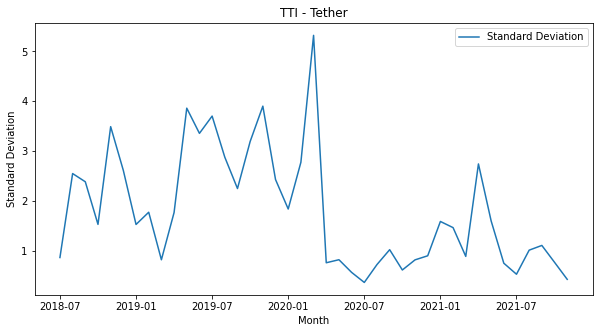

In [43]:
#@title Create the Graph

if TTIVal[4] == TTI.value:
  TTIselected = SD
  xval = TTIselected.map(lambda x: x[0]).collect()
  yval = TTIselected.map(lambda x: x[1]).collect()
  plt.ylabel("Standard Deviation")
  plt.xlabel("Month")
  #plt.xticks(xval[::10])
else:
  if TTIVal[0] == TTI.value:
    TTIselected = MovingAvg
  elif  TTIVal[1] == TTI.value:
    TTIselected = MACD
  elif  TTIVal[2] == TTI.value:
    TTIselected = RSI
  elif  TTIVal[3] == TTI.value:
    TTIselected = SRSI

  xval = TTIselected.rdd.map(lambda x: x[0][:7]).collect()
  yval = TTIselected.rdd.map(lambda x: x[1]).collect()
  plt.ylabel("Crypto Currency Price (USDT)")
  plt.xlabel("Date")
  # f = plt.figure()
  # f.set_figwidth(200)
  # f.set_figheight(10)
plt.plot(xval, yval, label = TTI.value)

if TTIVal[4] == TTI.value:
  plt.xticks(xval[::6])
else:
  plt.xticks(xval[::200])

plt.legend(loc="upper right")
plt.title("TTI - "+ coinname)
plt.rcParams["figure.figsize"] = (10,5)

plt.show()